# Loading and saving the dataset

In [1]:
from datasets import load_dataset

# Load dataset from huggingface
dataset = load_dataset("Micol/musical-instruments-sound-dataset")

In [2]:
# Optional -> save to disk to prevent re-download
# dataset.save_to_disk("data/")

---------
# Dataset preprocessing

In [3]:
import torch
import numpy as np
from scipy.ndimage import zoom
from librosa import power_to_db
from torchaudio.transforms import MelSpectrogram, Resample
from torch.utils.data import DataLoader, Dataset as TorchDataset

In [4]:
# Mel parameters
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512

In [5]:
# Define a custom PyTorch Dataset for pre-processing
class AudioDataset(TorchDataset):
    def __init__(self, dataset, target_sr=44100):
        """
        Custom PyTorch Dataset for audio classification.
        
        Args:
            dataset: Hugging Face dataset containing 'audio' and 'label' columns.
            target_sr: Target sampling rate to resample all audio.
        """
        self.dataset = dataset
        self.target_sr = target_sr

        # Mel Spectrogram transform
        self.mel_transform = MelSpectrogram(
            sample_rate=target_sr, 
            n_fft=N_FFT, 
            hop_length=HOP_LENGTH, 
            n_mels=N_MELS
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load audio and label
        audio_array = self.dataset[idx]['audio']['array']
        sr = self.dataset[idx]['audio']['sampling_rate']
        label = self.dataset[idx]['label']
        
        # Convert to PyTorch tensor
        audio_tensor = torch.tensor(audio_array, dtype=torch.float32)

        # Resample if needed
        if sr != self.target_sr:
            resample_transform = Resample(orig_freq=sr, new_freq=self.target_sr)
            audio_tensor = resample_transform(audio_tensor)

        # Generate spectrogram
        mel_spectrogram = self.mel_transform(audio_tensor)

        # Convert to power spectrogram
        mel_spectrogram_db = power_to_db(mel_spectrogram, ref=np.max)

        # Resize
        shape = (128,128)
        mel_spec_db_resized = np.zeros(shape)
        mel_spec_db_resized[:mel_spectrogram_db.shape[0], :mel_spectrogram_db.shape[1]] = mel_spectrogram_db[:shape[0], :shape[1]]
        mel_spec_db_resized = torch.tensor(mel_spec_db_resized, dtype=torch.float32)

        return mel_spec_db_resized, label

In [6]:
# Split dataset into train and test sets
train_dataset = AudioDataset(dataset['train'])
validation_dataset = AudioDataset(dataset['validation'])
test_dataset = AudioDataset(dataset['test'])

In [7]:
# Define DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

----
# Model implementation

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [17]:
class AudioClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AudioClassifier, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1) 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) 
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Tring with pooling layers
        x = F.relu(self.conv1(x)) 
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        # Flatten the output of the last convolutional layer
        x = torch.flatten(x, 1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
# Number of classes based on dataset
num_classes = len(dataset['train'].features['label'].names)

# Instantiate the model
model = AudioClassifier(num_classes=num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer, loss function and scheduler this time
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [19]:
from tqdm import tqdm

# train loop
def train(model, train_loader, validation_loader, criterion, optimizer, device, epochs, scheduler = None):
    best_accuracy = 0.0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for mel_spectrograms, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            mel_spectrograms = mel_spectrograms.unsqueeze(1).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(mel_spectrograms)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for mel_spectrograms, labels in validation_loader:
                mel_spectrograms = mel_spectrograms.unsqueeze(1).to(device)
                labels = labels.to(device)

                outputs = model(mel_spectrograms)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(validation_loader)
        val_accuracy = correct / total

        # Step the scheduler if it exists
        if scheduler is not None:
            scheduler.step(avg_val_loss)

        # Save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_state = model.state_dict()

        print(f"Epoch {epoch+1}: "
              f"Train Loss = {avg_train_loss:.4f}, "
              f"Train Accuracy = {train_accuracy:.4f}, "
              f"Val Loss = {avg_val_loss:.4f}, "
              f"Val Accuracy = {val_accuracy:.4f}")

    return best_model_state, best_accuracy

In [20]:
#train(model, train_loader, validation_loader, criterion, optimizer, device, epochs=50)
best_model_state, best_accuracy = train(
    model=model,
    train_loader=train_loader,
    validation_loader=validation_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=50,
    scheduler=scheduler
)

Epoch 1/50: 100%|██████████| 132/132 [01:08<00:00,  1.92it/s]


Epoch 1: Train Loss = 2.0932, Train Accuracy = 0.5506, Val Loss = 0.6321, Val Accuracy = 0.6844


Epoch 2/50: 100%|██████████| 132/132 [01:08<00:00,  1.92it/s]


Epoch 2: Train Loss = 0.6319, Train Accuracy = 0.6838, Val Loss = 0.7012, Val Accuracy = 0.6711


Epoch 3/50: 100%|██████████| 132/132 [01:08<00:00,  1.92it/s]


Epoch 3: Train Loss = 0.5608, Train Accuracy = 0.6895, Val Loss = 0.5676, Val Accuracy = 0.6730


Epoch 4/50: 100%|██████████| 132/132 [01:08<00:00,  1.92it/s]


Epoch 4: Train Loss = 0.5590, Train Accuracy = 0.6890, Val Loss = 0.5886, Val Accuracy = 0.6901


Epoch 5/50: 100%|██████████| 132/132 [01:08<00:00,  1.92it/s]


Epoch 5: Train Loss = 0.5118, Train Accuracy = 0.6904, Val Loss = 0.5351, Val Accuracy = 0.6730


Epoch 6/50: 100%|██████████| 132/132 [01:08<00:00,  1.92it/s]


Epoch 6: Train Loss = 0.4990, Train Accuracy = 0.7009, Val Loss = 0.5435, Val Accuracy = 0.6806


Epoch 7/50: 100%|██████████| 132/132 [01:09<00:00,  1.89it/s]


Epoch 7: Train Loss = 0.5166, Train Accuracy = 0.6923, Val Loss = 0.5416, Val Accuracy = 0.6920


Epoch 8/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 8: Train Loss = 0.5077, Train Accuracy = 0.6914, Val Loss = 0.5497, Val Accuracy = 0.6901


Epoch 9/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 9: Train Loss = 0.4808, Train Accuracy = 0.7118, Val Loss = 0.5372, Val Accuracy = 0.6806


Epoch 10/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 10: Train Loss = 0.4498, Train Accuracy = 0.7066, Val Loss = 0.5308, Val Accuracy = 0.6521


Epoch 11/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 11: Train Loss = 0.4438, Train Accuracy = 0.7228, Val Loss = 0.5337, Val Accuracy = 0.6749


Epoch 12/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 12: Train Loss = 0.4408, Train Accuracy = 0.7266, Val Loss = 0.5360, Val Accuracy = 0.6426


Epoch 13/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 13: Train Loss = 0.4403, Train Accuracy = 0.7204, Val Loss = 0.5384, Val Accuracy = 0.6350


Epoch 14/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 14: Train Loss = 0.4391, Train Accuracy = 0.7133, Val Loss = 0.5366, Val Accuracy = 0.6350


Epoch 15/50: 100%|██████████| 132/132 [01:08<00:00,  1.91it/s]


Epoch 15: Train Loss = 0.4359, Train Accuracy = 0.7271, Val Loss = 0.5365, Val Accuracy = 0.6369


Epoch 16/50: 100%|██████████| 132/132 [01:09<00:00,  1.91it/s]


Epoch 16: Train Loss = 0.4309, Train Accuracy = 0.7304, Val Loss = 0.5367, Val Accuracy = 0.6407


Epoch 17/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 17: Train Loss = 0.4316, Train Accuracy = 0.7328, Val Loss = 0.5371, Val Accuracy = 0.6445


Epoch 18/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 18: Train Loss = 0.4306, Train Accuracy = 0.7342, Val Loss = 0.5377, Val Accuracy = 0.6445


Epoch 19/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 19: Train Loss = 0.4300, Train Accuracy = 0.7294, Val Loss = 0.5378, Val Accuracy = 0.6445


Epoch 20/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 20: Train Loss = 0.4324, Train Accuracy = 0.7366, Val Loss = 0.5378, Val Accuracy = 0.6426


Epoch 21/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 21: Train Loss = 0.4320, Train Accuracy = 0.7299, Val Loss = 0.5379, Val Accuracy = 0.6445


Epoch 22/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 22: Train Loss = 0.4326, Train Accuracy = 0.7252, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 23/50: 100%|██████████| 132/132 [01:09<00:00,  1.91it/s]


Epoch 23: Train Loss = 0.4275, Train Accuracy = 0.7337, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 24/50: 100%|██████████| 132/132 [01:09<00:00,  1.91it/s]


Epoch 24: Train Loss = 0.4321, Train Accuracy = 0.7261, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 25/50: 100%|██████████| 132/132 [01:09<00:00,  1.91it/s]


Epoch 25: Train Loss = 0.4327, Train Accuracy = 0.7375, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 26/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 26: Train Loss = 0.4319, Train Accuracy = 0.7342, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 27/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 27: Train Loss = 0.4310, Train Accuracy = 0.7385, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 28/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 28: Train Loss = 0.4325, Train Accuracy = 0.7171, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 29/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 29: Train Loss = 0.4320, Train Accuracy = 0.7266, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 30/50: 100%|██████████| 132/132 [01:09<00:00,  1.91it/s]


Epoch 30: Train Loss = 0.4349, Train Accuracy = 0.7271, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 31/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 31: Train Loss = 0.4350, Train Accuracy = 0.7318, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 32/50: 100%|██████████| 132/132 [01:09<00:00,  1.91it/s]


Epoch 32: Train Loss = 0.4277, Train Accuracy = 0.7361, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 33/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 33: Train Loss = 0.4296, Train Accuracy = 0.7328, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 34/50: 100%|██████████| 132/132 [01:09<00:00,  1.91it/s]


Epoch 34: Train Loss = 0.4328, Train Accuracy = 0.7332, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 35/50: 100%|██████████| 132/132 [01:09<00:00,  1.91it/s]


Epoch 35: Train Loss = 0.4338, Train Accuracy = 0.7337, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 36/50: 100%|██████████| 132/132 [01:09<00:00,  1.89it/s]


Epoch 36: Train Loss = 0.4332, Train Accuracy = 0.7370, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 37/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 37: Train Loss = 0.4310, Train Accuracy = 0.7342, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 38/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 38: Train Loss = 0.4318, Train Accuracy = 0.7285, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 39/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 39: Train Loss = 0.4298, Train Accuracy = 0.7351, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 40/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 40: Train Loss = 0.4299, Train Accuracy = 0.7199, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 41/50: 100%|██████████| 132/132 [01:09<00:00,  1.91it/s]


Epoch 41: Train Loss = 0.4284, Train Accuracy = 0.7513, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 42/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 42: Train Loss = 0.4297, Train Accuracy = 0.7304, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 43/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 43: Train Loss = 0.4301, Train Accuracy = 0.7366, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 44/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 44: Train Loss = 0.4309, Train Accuracy = 0.7256, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 45/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 45: Train Loss = 0.4295, Train Accuracy = 0.7313, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 46/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 46: Train Loss = 0.4259, Train Accuracy = 0.7370, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 47/50: 100%|██████████| 132/132 [01:09<00:00,  1.89it/s]


Epoch 47: Train Loss = 0.4290, Train Accuracy = 0.7328, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 48/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 48: Train Loss = 0.4339, Train Accuracy = 0.7370, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 49/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 49: Train Loss = 0.4325, Train Accuracy = 0.7361, Val Loss = 0.5380, Val Accuracy = 0.6407


Epoch 50/50: 100%|██████████| 132/132 [01:09<00:00,  1.90it/s]


Epoch 50: Train Loss = 0.4285, Train Accuracy = 0.7408, Val Loss = 0.5380, Val Accuracy = 0.6407


-----
# Evaluate

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Test Accuracy: 0.4750
Confusion Matrix:


<Figure size 1000x700 with 0 Axes>

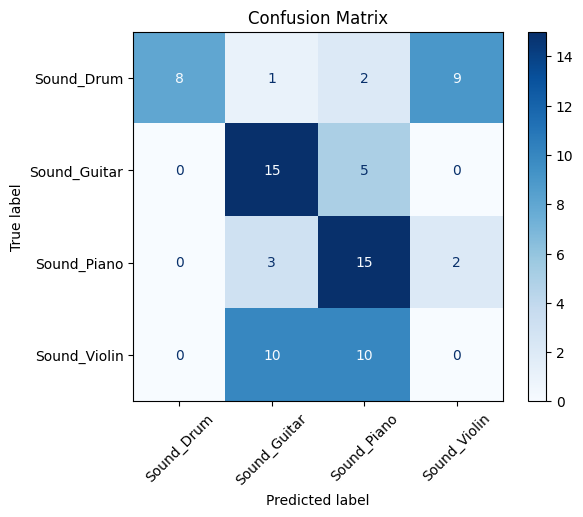

In [22]:
def evaluate(model, test_loader, device, class_names):
    model.eval()
    correct = 0
    total = 0
    
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for mel_spectrograms, labels in test_loader:
            mel_spectrograms, labels = mel_spectrograms.unsqueeze(1).to(device), labels.to(device)

            outputs = model(mel_spectrograms)
            _, predicted = torch.max(outputs, 1)

            # Track overall accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save all labels and predictions for the confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate accuracy
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot confusion matrix
    print("Confusion Matrix:")
    plt.figure(figsize=(10, 7))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45)
    plt.show()

# Evaluate on test set
evaluate(model, test_loader, device, dataset['train'].features['label'].names)

In [24]:
torch.save(model.state_dict(), 'sixth_idea.pth')